In [12]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

基于位置的前馈网络

In [13]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs) -> None:
        super(PositionWiseFFN, self).__init__(**kwargs)

        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return(self.dense2(self.relu(self.dense1(X))))

In [14]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).size()

torch.Size([2, 3, 8])

对比不同维度的layer norm和batch norm的区别

In [15]:
# layernrom针对的是同一个sample下同一个feature进行归一化
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)

X = torch.tensor(
    [ [1, 2],[3, 4] ], dtype=torch.float32)
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


使用残差链接和归一化

In [16]:
# 需要给出归一化模型大小
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs) -> None:
        super(AddNorm, self).__init__(**kwargs)

        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    # 原始输入X与tranformer输出的Y
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


实现编码器的一层

In [17]:
# transformer编码器中的任何层都不会改变其输入的形状。
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs) -> None:
        super(EncoderBlock, self).__init__(**kwargs)

        self.attention = d2l.MultiHeadAttention(
                    key_size, query_size, value_size,num_hiddens,num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # 将X分别作为Q K V投入进MultiHandAttention
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [18]:
# transformer编码器中的任何层都不会改变其输入的形状。
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [19]:
class TransformerEncoder(d2l.Encoder):
    """transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                 num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)

        self.num_hiddens = num_hiddens
        
        # 将最简单的vocab变换成 vocab-embeddding 的形式
        self.embedding = nn.Embedding(
            num_embeddings = vocab_size,
            embedding_dim = num_hiddens
            )
        
        # 根据维度大小来创建对应的位置函数
        self.pos_encoding = d2l.PositionalEncoding(
            num_hiddens=num_hiddens,
            dropout=dropout
        )
        
        self.blks = nn.Sequential()

        # 叠层操作
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i) ,
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias
                            )
            )

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行放大，
        # 然后再与位置编码相加。
        embedd = self.embedding(X)
        X = self.pos_encoding(embedd * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)

        for i, blk in enumerate(self.blks):

            # 由于Transformer输入输出大小不发生变化，很容易嵌套进循环里
            X = blk(X, valid_lens)

            # 此处保存了每一次的权重weight
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

指定了超参数来创建一个两层的transformer编码器

In [24]:
#     def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
#                  norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
#                  num_layers, dropout, use_bias=False, **kwargs):

encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

实现解码器的一层

In [26]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)

        # 用于保存目前是第几个输入词源，仅在预测时有效
        self.i = i

        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)

        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.addnorm3 = AddNorm(norm_shape, dropout)

        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)

    def forward(self, X, state):
        enc_outputs = state[0]
        enc_valid_lens = state[1]

        # 如果是 training 阶段，那么输出序列不需要上一次的输出结果，而是用的样本的正确值
        # 并且输出序列的所有词源在同一时间处理
        # 因此state[2][self.i] = None
        if state[2][self.i] is None:
            key_values = X
        else:
            # 在预测阶段，需要把i之前所有的解码块的输出保存在state[2][self.i]中
            # 输出序列是由词源一个接一个输出的过程
            key_values = torch.cat((state[2][self.i], X), axis = 1)
        
        # state[2][self.i] 只保留第 i 个之前的状态信息
        state[2][self.i] = key_values

        if self.training:
            batch_size, num_steps, _ = X.shape

            # 获得了num_steps之后就可以构建序列来遮掩padding时产生的无用数据
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:
            # prediction 一个一个输出 本身就看不到最后 并且会在eos处停止
            dec_valid_lens = None

        # 第一重 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)

        # 第二重 编码器－解码器注意力
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)

        output = self.addnorm3(Z, self.ffn(Z))
        return output, state



In [27]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [29]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)

        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()

        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))

        # Linear作为Decoder输出
        self.dense = nn.Linear(num_hiddens, vocab_size)
    
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
        
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]

        for i,block in enumerate(self.blks):
            X, state = block(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = block.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = block.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

训练开始

loss 0.031, 3538.6 tokens/sec on cuda:0


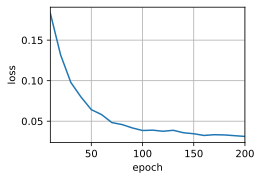

In [30]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

# return X
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

# return self.dense(X), state
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture.

    Defined in :numref:`sec_encoder-decoder`"""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)  

In [31]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [32]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

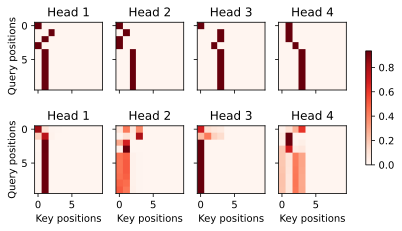

In [33]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [34]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

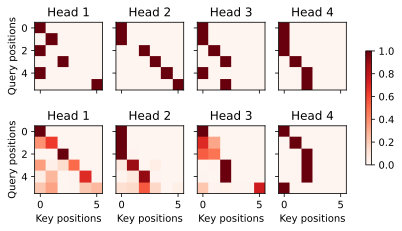

In [35]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

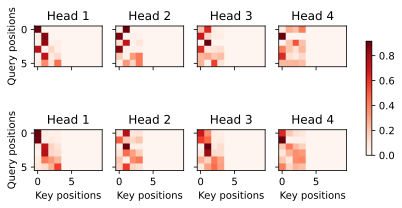

In [36]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))